# Installation & Setup

Install some python packages

In [7]:
# %pip install us
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install plotnine

Import those packages

In [8]:
# Inline Chart Parameters
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import pandas as pd
import numpy as np
import us
from datetime import datetime, timedelta
from plotnine import *

# Display all columns on tables
pd.set_option('display.max_columns', None)

In [9]:
# Download some data
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/raw-polls.csv")\
  .to_csv('raw-polls.csv', index=False)

# Download some data
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/pollster-ratings.csv")\
  .to_csv('pollster-ratings.csv', index=False)

# Thinking About An Upcoming Election

Can we trust the polls? And if so...how much?

Let's see how polls have been doing so far!

## Getting some data

Today we'll be working with data from [FiveThirtyEight's Pollster Ratings project](http://projects.fivethirtyeight.com/pollster-ratings/). 

This data contains:
* Every poll that FiveThirtyEight has collected in the last 21 days prior to general election (pres, senate, house, governor) or presidential primary.
* And... results for those elections!

In [10]:
# Load some data into variables
polls = pd.read_csv('raw-polls.csv')

# Reverses some values so that Democratic is on the left (-) and Republican is on the right (+)
polls['margin_poll'] = -polls['margin_poll']
polls['margin_actual'] = -polls['margin_actual']
polls['bias'] = -polls['bias']
polls['bias_overestimate'] = polls.bias.apply(lambda x: 'overestimates democrat' if x < 0 else 'overestimates republican')
polls['bias_overestimate'] = pd.Categorical(polls['bias_overestimate'], categories=['overestimates republican','overestimates democrat'])

# Create a variable to distinguish national vs state polls and for winner party
polls['national'] = polls.location.apply(lambda x: 'national' if x == 'US' else 'state')
polls['winner_party'] = polls.margin_actual.apply(lambda x: 'D' if x < 0 else 'R')
polls['winner_party'] = pd.Categorical(polls['winner_party'], categories=['R','D'])

polls.tail(2)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party
10774,73992,138821,8737,2020,2020_Sen-GR_GA,GA,Sen-G,Sen-GR,Opinion Savvy/InsiderAdvantage,243,IVR/Live Phone,NaN,1/3/2021,500.0,Jon Ossoff,14567,DEM,48.6,David A. Perdue,14568,REP,48.7,NaN,0.1,1/5/2021,50.61,49.39,-1.23,1.33,1.33,0.0,-1.85676,for Fox 5 Atlanta,overestimates republican,state,D
10775,74006,138845,8737,2020,2020_Sen-GR_GA,GA,Sen-G,Sen-GR,Trafalgar Group,338,IVR/Online/Text,R,1/3/2021,1056.0,Jon Ossoff,14567,DEM,49.4,David A. Perdue,14568,REP,48.5,NaN,-0.9,1/5/2021,50.61,49.39,-1.23,0.33,0.33,1.0,-2.37262,for unspecified Republican sponsor,overestimates republican,state,D


## Nationwide Presidential Polls

Lets look at polls of the Nationwide popular vote. First, an exploratory visualization.

In [11]:
# Get all NATIONAL-level presidential polls
polls_to_analyze = polls.query("type_detail=='Pres-G' and location=='US'")

# Display 3 random polls
polls_to_analyze.sample(3)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party
6847,30799,37160,37,2012,2012_Pres-G_US,US,Pres-G,Pres-G,IBD/TIPP,144,Live Phone,NaN,11/4/2012,712.0,Barack Obama,16,DEM,50.3,Mitt Romney,9,REP,48.7,NaN,-1.6,11/6/2012,51.02,47.18,-3.85,2.25,2.25,1.0,-0.971396,NaN,overestimates republican,national,D
1088,63530,121979,40,2000,2000_Pres-G_US,US,Pres-G,Pres-G,ABC News/The Washington Post,3,Live Phone,NaN,11/4/2000,1801.0,Al Gore,222,DEM,46.0,George W. Bush,241,REP,49.0,3.0,3.0,11/7/2000,48.31,47.79,-0.51,3.51,3.51,0.0,0.356509,for The Washington Post; average of multiple v...,overestimates republican,national,D
9879,71373,133650,6210,2020,2020_Pres-G_US,US,Pres-G,Pres-G,YouGov,391,Online,NaN,10/17/2020,1465.0,Joseph R. Biden Jr.,13256,DEM,51.0,Donald Trump,13254,REP,40.0,NaN,-11.0,11/3/2020,51.31,46.86,-4.45,6.55,-6.55,1.0,2.388484,for Yahoo News,overestimates democrat,national,D


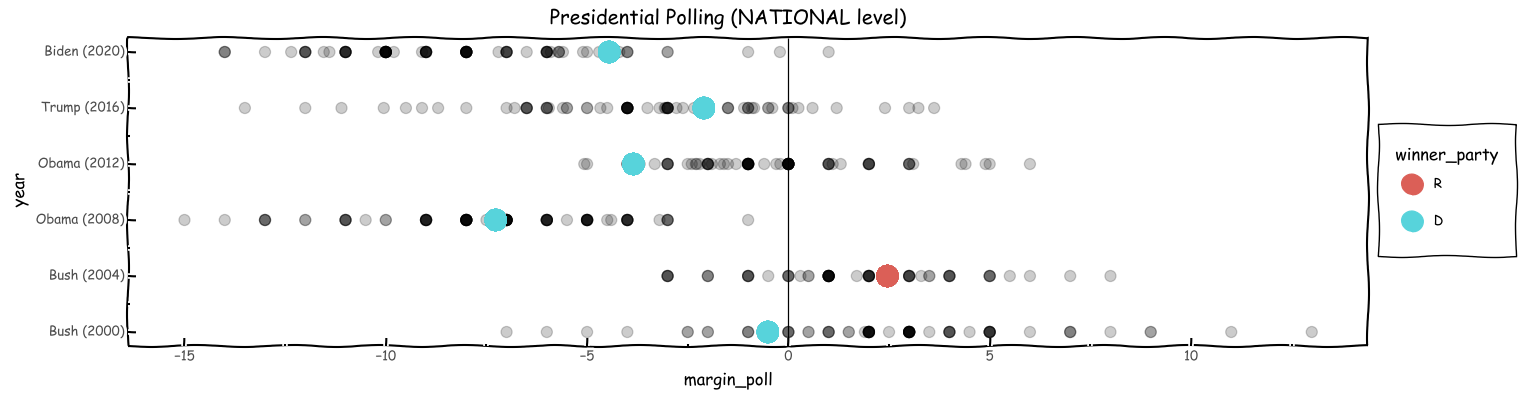

<ggplot: (357469148)>

In [12]:
(
    ggplot(polls_to_analyze, aes(x='margin_poll', y='year'))
     + geom_point(size=4, alpha=.2)
     + geom_point(aes(x='margin_actual', color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + scale_y_continuous(breaks=list(range(2000,2024,4)), 
                          labels=list(reversed(['Biden (2020)', 'Trump (2016)', 'Obama (2012)', 'Obama (2008)', 'Bush (2004)', 'Bush (2000)'])))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + labs(title='Presidential Polling (NATIONAL level)')
)

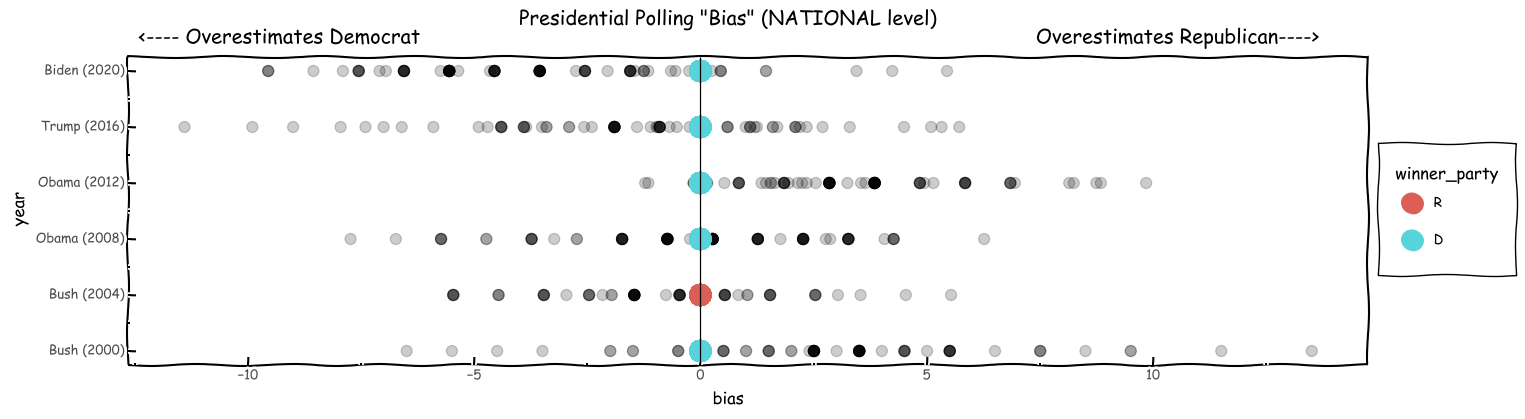

<ggplot: (357596401)>

In [14]:
# Plotting "bias" rather than margin, since we care about how far off the poll was from the actual result
(
    ggplot(polls_to_analyze, aes(x='bias', y='year'))
     + geom_point(size=4, alpha=.2)
     + geom_point(aes(x=0, color="winner_party"), size=8)
     + geom_vline(aes(xintercept=0))
     + scale_y_continuous(breaks=list(range(2000,2024,4)), 
                          labels=list(reversed(['Biden (2020)', 'Trump (2016)', 'Obama (2012)', 'Obama (2008)', 'Bush (2004)', 'Bush (2000)'])))
     + theme_xkcd()
     + theme(figure_size=(16, 4)) 
     + labs(title='Presidential Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What do you notice about this chart?

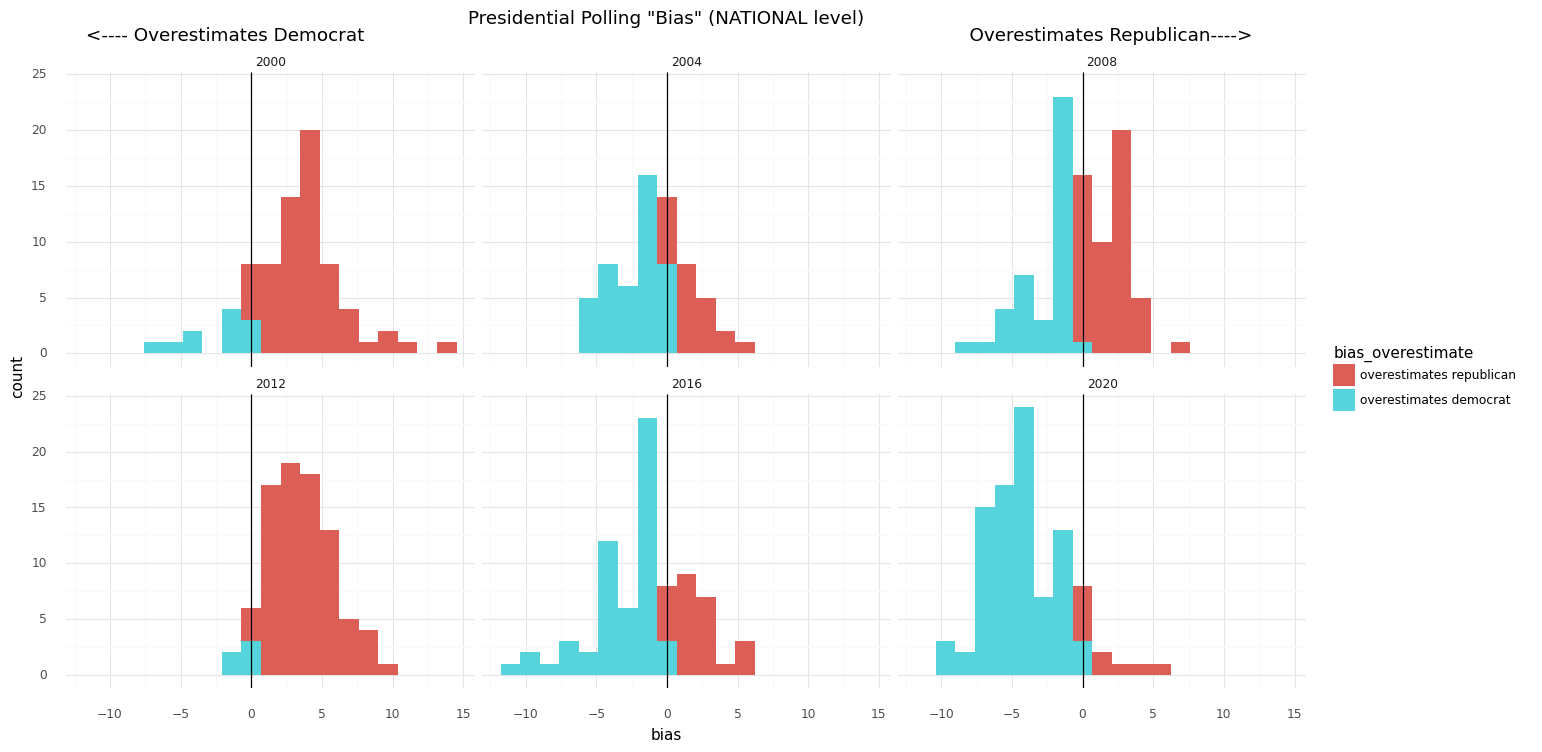

<ggplot: (357751185)>

In [17]:
# Here is another view
(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias_overestimate'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_wrap('~year')
     + theme(figure_size=(16, 8)) 
     + labs(title='Presidential Polling "Bias" (NATIONAL level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What have we noticed about the presidential polls at the national level?

<details><summary> ---> DON'T CLICK ME </summary>
<p>

* Even if MoE Is +/-3 for example, in practice there are other sources of error. Histoircally polls have been more like +/-5 pts on average.
* Polls sometimes miss in the same direction in any given year.
```

</p>
</details>

### How might this impact how you report on a new poll that comes out?



<details><summary> ---> DON'T CLICK ME </summary>
<p>

* Place individual polls in their aggregate context
* Convey uncertainty appropriately

</p>
</details>

## But, we don't have one Presidential election in the U.S. ... 
...we have 50 separate ones (plus DC and some quirks in Maine and Nebraska). And the nationwide polls can only tell us so much about who might win the election. So what about state polling? Has it been getting better or worse over the years? Can we still rely on it this coming election cycle? 


In [18]:
# A quick look at the polls dataframe
presidential_state_level_polls = polls.query("type_detail=='Pres-G' and location!='US'")
presidential_state_level_polls.head(2)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party
471,6483,7952,815,2000,2000_Pres-G_FL,FL,Pres-G,Pres-G,McLaughlin & Associates,203,Live Phone,R,10/17/2000,600.0,Al Gore,222,DEM,43.0,George W. Bush,241,REP,44.0,3.0,1.0,11/7/2000,48.84,48.85,0.01,0.99,0.99,1.0,-3.534693,for Bill McCollum,overestimates republican,state,R
472,6470,7939,820,2000,2000_Pres-G_IL,IL,Pres-G,Pres-G,KRC Research,160,Live Phone,NaN,10/17/2000,600.0,Al Gore,222,DEM,45.0,George W. Bush,241,REP,43.0,4.0,-2.0,11/7/2000,54.60,42.58,-12.01,10.01,10.01,1.0,3.420487,NaN,overestimates republican,state,D


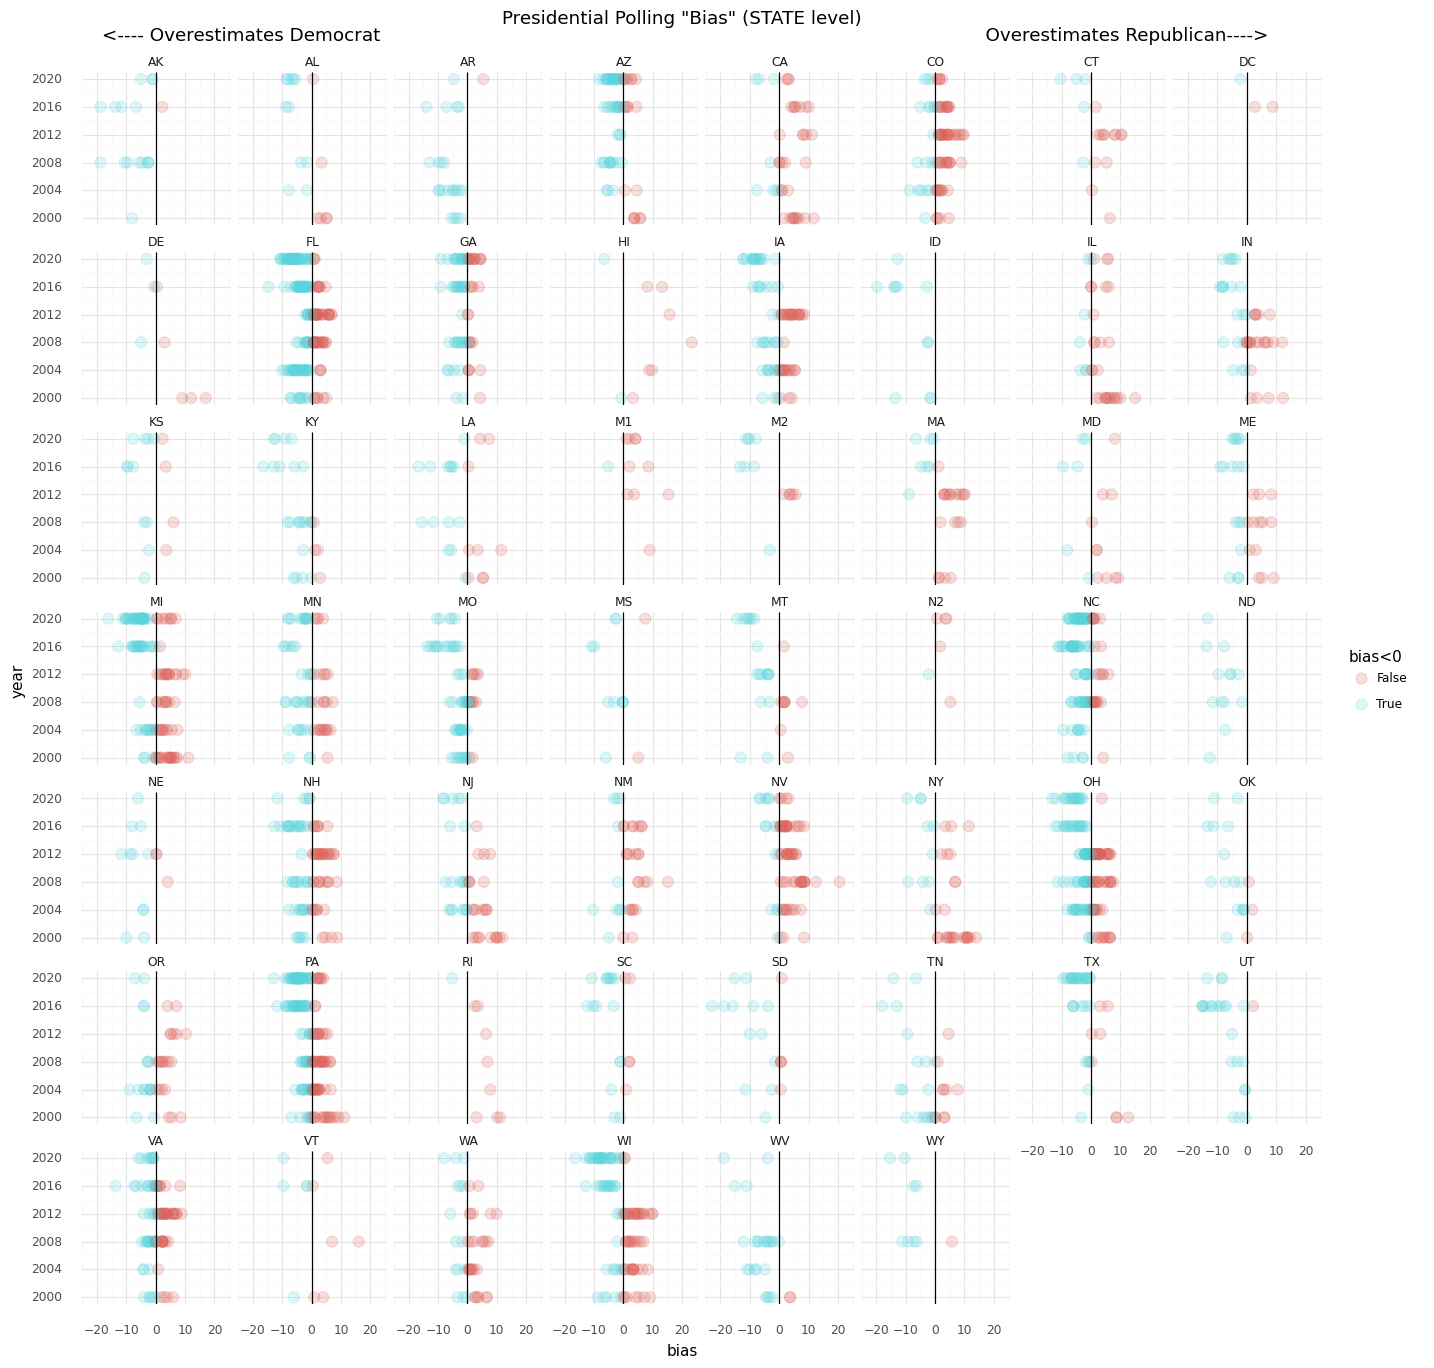

<ggplot: (358243063)>

In [19]:
(
    ggplot(presidential_state_level_polls
           , aes(x='bias', y='year', color='bias<0'))
     + geom_point(size=4, alpha=.2)
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + scale_y_continuous(breaks=list(range(2000,2024,4)))
     + facet_wrap('~location')
     + theme(figure_size=(16, 16)) 
         + labs(title='Presidential Polling "Bias" (STATE level)\n <---- Overestimates Democrat                                                                                                       Overestimates Republican---->')

)

### What have we noticed about the presidential polls at the state level compared to the national level?

<details><summary> ---> DON'T CLICK ME </summary>
<p>

* State level polls seem less accurate than national polls
* Some states have a lot more polling than others
* Polling in Hawaii is historically super inaccurate
* State level polling errors are correlated in any given year
```

</p>
</details>


In [20]:
presidential_state_level_polls[['year', 'location', 'pollster', 'bias', 'error']]\
    .groupby('year').mean().round(2)

,bias,error
year,,
2000,1.93,4.55
2004,-0.98,3.29
2008,-0.04,3.60
2012,2.32,3.66
2016,-3.73,5.38
2020,-4.12,4.96


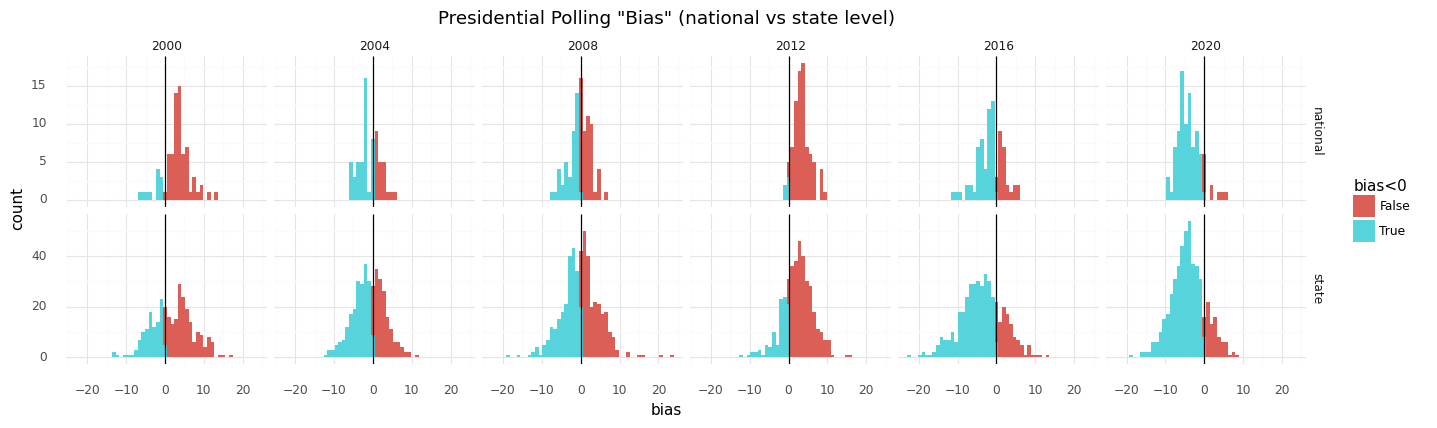

<ggplot: (378714037)>

In [25]:
# state-level presidential polls over the years
polls_to_analyze = polls.query("type_detail=='Pres-G'")

(
    ggplot(polls_to_analyze, aes(x='bias', fill='bias<0'))
     + geom_histogram()
     + geom_vline(aes(xintercept=0))
     + theme_minimal()
     + facet_grid('national~year', scales='free_y')
     + theme(figure_size=(16, 4)) 
     + labs(title='Presidential Polling "Bias" (national vs state level)')

)

## What about polling in primary elections?

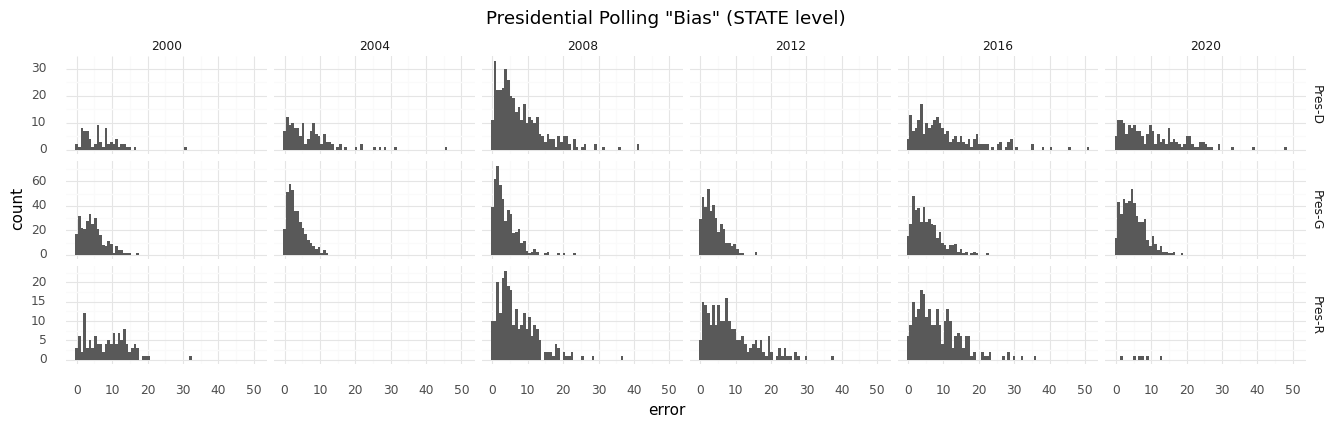

<ggplot: (358249876)>

type_detail,Pres-D,Pres-G,Pres-R
year,,,
2000,6.5,4.6,8.8
2004,7.1,3.3,
2008,7.7,3.6,7.0
2012,,3.7,8.6
2016,10.5,5.4,8.3
2020,10.3,5.0,7.2


In [30]:
# Primary and general elections
polls_to_analyze = polls.query("type_detail.isin(['Pres-G', 'Pres-R', 'Pres-D']) and error.notna()")
polls_to_analyze = polls_to_analyze.query("national=='state'")

# polls_to_analyze = polls_to_analyze.query("location.isin(@swing_states_2020)")
display(
    ggplot(polls_to_analyze, aes(x='error'))
     + geom_histogram()
     + theme_minimal()
     + facet_grid('type_detail~year', scales='free_y')
     + theme(figure_size=(16, 4)) 
     + labs(title='Presidential Polling "Bias" (STATE level)')

)

display(
    polls_to_analyze.pivot_table(index='type_detail', values='error', columns='year',aggfunc='mean').T.round(1).fillna('')
)

## And how about Senate, House, Governor, etc...?

In [31]:
(
    polls
    .pivot_table(index=['type_simple'], values='error', columns='national',aggfunc='mean')
    .round(1)
    .fillna('')
)


national,national,state
type_simple,,
Gov-G,,5.1
House-G,4.0,6.3
Pres-G,3.1,4.3
Pres-P,,8.4
Sen-G,,5.2


# Are polls becoming less accurate over time? 

In [32]:
(
    polls.query('year%2==0')
    .pivot_table(index=['type_simple', 'national'], values='error', columns='year',aggfunc='mean')
    .round(1)
    .fillna('')
    .T
)


type_simple Gov-G  House-G         Pres-G       Pres-P Sen-G
national    state national state national state  state state
year                                                        
1998          8.1      4.6   8.3                         6.8
2000          3.7      3.4   5.6      3.7   4.6    7.9   5.4
2002          5.4      5.0   5.7                         4.9
2004          3.2      4.7   5.6      2.2   3.3    7.1   5.0
2006          4.7      6.9   5.9                         5.2
2008          4.7      2.8   6.4      2.2   3.6    7.4   4.9
2010          4.7      3.2   7.2                         5.4
2012          4.7      1.8   6.1      3.5   3.7    8.6   4.7
2014          4.8      4.5   7.0                         5.3
2016          6.2      2.7   6.9      2.9   5.4    9.4   5.4
2018          4.7      3.7   5.1                         4.1
2020          7.0      4.7   7.3      4.2   5.0   10.2   5.6

# Part 2: Statistical Treatment

Statistical treatment can help you get more out of a dataset! Sometimes the polls miss, but have consistent biases one way or another. If we can detect these patterns, we can correct for them and get more out of the data. Here is one example of how. Let's take a look at what we know about each pollster

- Pollster Ratings: https://projects.fivethirtyeight.com/pollster-ratings/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/
- Latest Update: https://fivethirtyeight.com/features/the-state-of-the-polls-2019/

In [33]:
pollster_ratings = pd.read_csv('pollster-ratings.csv').set_index('Pollster Rating ID')
pollster_ratings.head()

,Rank,Pollster,Polls Analyzed,NCPP/AAPOR/Roper,Banned by 538,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,Races Called Correctly,Misses Outside MOE,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,# of Polls for Bias Analysis,Bias,House Effect,Average Distance from Polling Average (ADPA),Herding Penalty
Pollster Rating ID,,,,,,,,,,,,,,,,,,,,
304,1,Selzer & Co.,50,yes,no,-1.164872,A+,0.106846,0.780000,0.240000,4.562133,5.959977,-1.392989,-1.623991,-1.006764,33,0.201305,-0.243631,5.339089,0.000000
3,2,ABC News/The Washington Post,82,yes,no,-0.991960,A+,0.919807,0.737805,0.085366,3.053507,4.972745,-1.914383,-1.328717,-0.980676,77,1.256719,1.231279,3.827492,0.132349
448,3,Siena College/The New York Times Upshot,83,yes,no,-0.954452,A+,1.142941,0.728916,0.204819,4.352682,5.364920,-1.007384,-1.309741,-1.055391,82,1.422586,0.231204,3.574594,0.225522
144,4,IBD/TIPP,31,yes,no,-0.938424,A+,-0.832351,0.806452,0.032258,2.085002,4.009343,-1.919487,-1.512109,-0.792614,31,-1.587916,-1.814818,3.704195,0.099455
94,5,Field Research Corp. (Field Poll),25,yes,no,-0.906695,A/B,-0.682868,1.000000,0.200000,4.103997,5.990497,-1.881646,-2.473643,-0.923134,18,-2.455076,0.725441,4.752571,0.000000


> **Mean-Reverted Bias** - A pollster's historical average statistical bias toward Democratic or Republican candidates, reverted to a mean of zero based on the number of polls in the database. A score of "R +1.5", for example, indicates that the pollster has historically overrated the performance of the Republican candidate.

In [35]:
# Append grade
polls['grade'] = polls.pollster_rating_id.apply(lambda x: pollster_ratings.loc[x]['538 Grade'] if x in pollster_ratings.index else None)

# Append MRB and chnage it to an integer value
polls['mrb'] = polls.pollster_rating_id.apply(lambda x: pollster_ratings.loc[x]['Mean-Reverted Bias'] if x in pollster_ratings.index else None)
# reverse polarity to match above charts where D is left (-) and R is right (+)
# polls['mrb'] = -pd.to_numeric(polls['mrb'].str.replace('D +', '', regex=False).str.replace('R +', '-', regex=False))

# Adjust poll, bias, and error by MRB
polls['margin_poll_adjusted'] = polls['margin_poll'] - polls['mrb']
polls['bias_adjusted'] = polls.margin_poll_adjusted - polls.margin_actual
polls['error_adjusted'] = np.abs(polls.margin_poll_adjusted - polls.margin_actual)

In [36]:
# Select all state and national polls
pres_polls_national = polls.query("type_detail=='Pres-G' and location=='US'")
pres_polls_by_state = polls.query("type_detail=='Pres-G' and location!='US'")

Let's look at some polls now! What do they look like with this insight applied? 

In [37]:
pres_polls_national.query('year==2016').sample(3)

,poll_id,question_id,race_id,year,race,location,type_simple,type_detail,pollster,pollster_rating_id,methodology,partisan,polldate,samplesize,cand1_name,cand1_id,cand1_party,cand1_pct,cand2_name,cand2_id,cand2_party,cand2_pct,cand3_pct,margin_poll,electiondate,cand1_actual,cand2_actual,margin_actual,error,bias,rightcall,advancedplusminus,comment,bias_overestimate,national,winner_party,grade,mrb,margin_poll_adjusted,bias_adjusted,error_adjusted
8250,47636,74556,94,2016,2016_Pres-G_US,US,Pres-G,Pres-G,Rasmussen Reports/Pulse Opinion Research,277,IVR/Online,NaN,10/26/2016,1500.0,Hillary Rodham Clinton,9207,DEM,45.0,Donald Trump,9849,REP,45.0,3.0,-0.0,11/8/2016,48.13,46.03,-2.1,2.1,2.1,0.5,-1.122893,NaN,overestimates republican,national,D,B,-1.466657,1.466657,3.566657,3.566657
8679,48509,76029,94,2016,2016_Pres-G_US,US,Pres-G,Pres-G,RKM Research and Communications Inc.,272,Live Phone,NaN,11/3/2016,1009.0,Hillary Rodham Clinton,9207,DEM,47.6,Donald Trump,9849,REP,44.4,4.3,-3.2,11/8/2016,48.13,46.03,-2.1,1.1,-1.1,1.0,-1.619406,for Boston Herald | Franklin Pierce University,overestimates democrat,national,D,B+,-0.153259,-3.046741,-0.946741,0.946741
8129,47327,74051,94,2016,2016_Pres-G_US,US,Pres-G,Pres-G,Rasmussen Reports/Pulse Opinion Research,277,IVR/Online,NaN,10/22/2016,1500.0,Hillary Rodham Clinton,9207,DEM,43.0,Donald Trump,9849,REP,42.0,5.0,-1.0,11/8/2016,48.13,46.03,-2.1,1.1,1.1,1.0,-2.384374,NaN,overestimates republican,national,D,B,-1.466657,0.466657,2.566657,2.566657


And in the aggregate for 2016? What about for other races? Other years?

In [40]:
pres_polls_national.query('year==2016')\
    [['year', 'location', 'pollster', 'error', 'error_adjusted', 'bias', 'bias_adjusted']]\
    .groupby('year').mean().round(1)

,error,error_adjusted,bias,bias_adjusted
year,,,,
2016,2.9,3.8,-1.6,-2.4


What about at the state level?

In [41]:
pres_polls_by_state.query('year==2016')\
    [['year', 'location', 'pollster', 'error', 'error_adjusted', 'bias', 'bias_adjusted']]\
    .groupby('year').mean().round(1)

,error,error_adjusted,bias,bias_adjusted
year,,,,
2016,5.4,6.7,-3.7,-5.3


Let's see what this means for national polls by pollster

In [42]:
pres_polls_national.query("year==2016")\
    [['year', 'location', 'pollster', 'error', 'error_adjusted']]\
    .groupby('pollster').agg(['mean', 'count'])\
    .sort_values(by=('error_adjusted', 'count'), ascending=False)\
    .drop([('year', 'count'), ('error', 'count')], axis=1)

year      error  \
                                                mean       mean   
pollster                                                          
Lucid                                         2016.0   2.785714   
Rasmussen Reports/Pulse Opinion Research      2016.0   2.100000   
Morning Consult                               2016.0   1.900000   
Gravis Marketing                              2016.0   1.360000   
Google Surveys                                2016.0   1.232500   
Ipsos                                         2016.0   4.175000   
IBD/TIPP                                      2016.0   1.687500   
ABC News/The Washington Post                  2016.0   1.825000   
Big Data Poll                                 2016.0   3.050000   
Fox News/Beacon Research/Shaw & Co. Research  2016.0   1.466667   
USC Dornsife/Los Angeles Times                2016.0   4.083333   
SurveyMonkey                                  2016.0   4.066667   
YouGov                                        2016.0   1.566667   
CVOTER                                        2016.0   0.883333   
NBC News/The Wall Street Journal              2016.0   4.900000   
CBS News/The New York Times                   2016.0   1.400000   
RAND (American Life Panel)                    2016.0   7.000000   
GfK Group                                     2016.0  11.400000   
Centre College                                2016.0   3.850000   
Suffolk University                            2016.0   7.950000   
Selzer & Co.                                  2016.0   0.900000   
Saint Leo University                          2016.0   9.000000   
Angus Reid Global                             2016.0   1.900000   
RKM Research and Communications Inc.          2016.0   1.100000   
CNN/Opinion Research Corp.                    2016.0   3.400000   
Insights West                                 2016.0   1.900000   
Public Policy Polling                         2016.0   3.900000   
Pew Research Center                           2016.0   4.400000   
GQR Research (GQRR)                           2016.0   9.900000   
Monmouth University                           2016.0   3.900000   
Marist College                                2016.0   0.600000   
American Research Group                       2016.0   4.900000   
Quinnipiac University                         2016.0   4.400000   

                                             error_adjusted        
                                                       mean count  
pollster                                                           
Lucid                                              4.394573     7  
Rasmussen Reports/Pulse Opinion Research           3.566657     5  
Morning Consult                                    4.820609     5  
Gravis Marketing                                   1.170721     5  
Google Surveys                                     1.166489     4  
Ipsos                                              5.767526     4  
IBD/TIPP                                           2.103675     4  
ABC News/The Washington Post                       2.444807     4  
Big Data Poll                                      3.484245     4  
Fox News/Beacon Research/Shaw & Co. Research       2.874269     3  
USC Dornsife/Los Angeles Times                     3.162907     3  
SurveyMonkey                                       8.808990     3  
YouGov                                             2.243301     3  
CVOTER                                             0.803687     3  
NBC News/The Wall Street Journal                   5.664102     2  
CBS News/The New York Times                        1.702559     2  
RAND (American Life Panel)                         7.173652     1  
GfK Group                                         11.599464     1  
Centre College                                     4.003755     1  
Suffolk University                                 8.864310     1  
Selzer & Co.                                       1.006846     1  
Sai

Lets look at a few particular cases. Hawaii, or Washington D.C. for example.

In [43]:
pres_polls_by_state.query("year==2016 and location=='HI'")\
    [['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'bias', 'bias_adjusted']]

,pollster,grade,margin_actual,margin_poll,margin_poll_adjusted,mrb,bias,bias_adjusted
8381,SurveyMonkey,C,-32.18,-19.0,-23.742323,4.742323,13.18,8.437677
8780,SurveyMonkey,C,-32.18,-24.0,-28.742323,4.742323,8.18,3.437677


Uh oh, what happened here? 

Beware of "unskewing" polls. Statistical treatments don't necessarily improve each individual poll result. But on average, when incoporated into your analysis they will help you get more information from the aggregate of your data.

Still, in the aggregate, you're better off looking at an adjusted average of the polls. Also, this is only one statsitical treatment! Remember how Hawaii polls tend to underestimate how well Democrats will do? We have adjusted for the pollster's average bias, but have not accounted for factors like that. And there are so many other things to consider! 

# Election Forecast Models

Let's talk about our election forecasts, which apply a lot of statistical treatments based on what we know about the nature of politics and political data in the U.S.


## Forecasts

### 2020 Forecast

- Forecast: https://projects.fivethirtyeight.com/2020-election-forecast/
- Methodology: https://fivethirtyeight.com/features/how-fivethirtyeights-2020-presidential-forecast-works-and-whats-different-because-of-covid-19/


### 2016 Forecast

- Forecast: https://projects.fivethirtyeight.com/2016-election-forecast/
- Methodology: https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/
- Analysis: https://projects.fivethirtyeight.com/2016-election-forecast/articles/?ex_cid=2016-forecast

### 2018 Forecast

- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/senate
- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house


## Polls Stories from 2016

These help elucidate how we turn analysis, like what you just did above, into insights for our readers.

- https://fivethirtyeight.com/features/how-much-the-polls-missed-by-in-every-state/
- https://fivethirtyeight.com/features/pollsters-probably-didnt-talk-to-enough-white-voters-without-college-degrees/
- https://fivethirtyeight.com/features/what-a-difference-2-percentage-points-makes/
- https://fivethirtyeight.com/features/shy-voters-probably-arent-why-the-polls-missed-trump/
- https://fivethirtyeight.com/features/the-polls-missed-trump-we-asked-pollsters-why/
- https://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/
- https://fivethirtyeight.com/features/the-polls-are-all-right/
- https://fivethirtyeight.com/features/trump-is-just-a-normal-polling-error-behind-clinton/



## Some other folks

- [CNN](https://www.cnn.com/election/2018/forecast)
- [Daily Kos](https://elections.dailykos.com/)
- [New York Times - Real Time Polling!](https://www.nytimes.com/interactive/2018/upshot/elections-polls.html)


# Visualizing Uncertainty

- FiveThirtyEight in [2010](https://www.nytimes.com/elections/2010/forecasts/senate.html), [2014](https://fivethirtyeight.com/interactives/senate-forecast/), [2016](https://projects.fivethirtyeight.com/2016-election-forecast/), [2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/)
    * I think 2010 still works in Safari...
- New York Times
    * The Spinners https://www.nytimes.com/2014/11/01/upshot/how-confirmation-bias-can-lead-to-a-spinning-of-wheels.html
    * The Needle https://www.youtube.com/watch?v=iq5rW6zYeP4
- [Huffpost's](http://elections.huffingtonpost.com/pollster) custom charts.

